Данные для визуализации загружены.
График 1: Распределение диагнозов


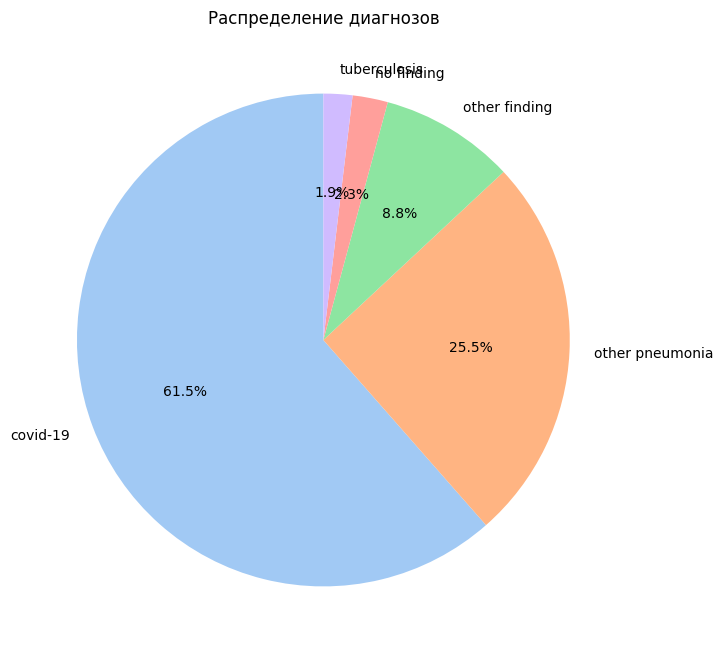

График 2: Распределение случаев COVID-19 по полу


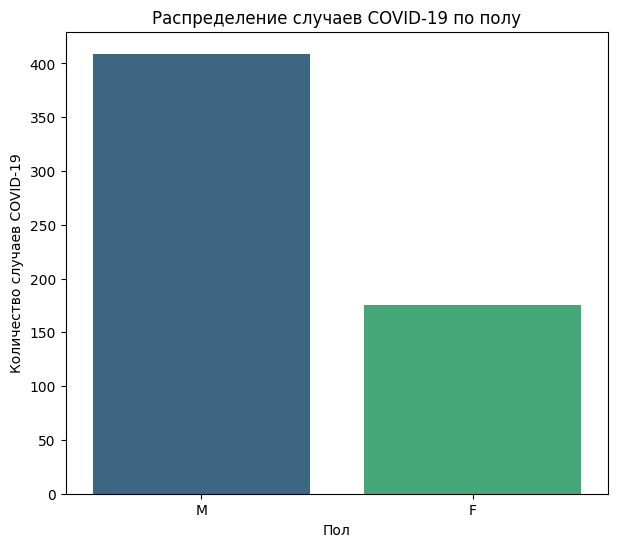


Визуализация 3: Динамика случаев COVID-19 по годам и месяцам


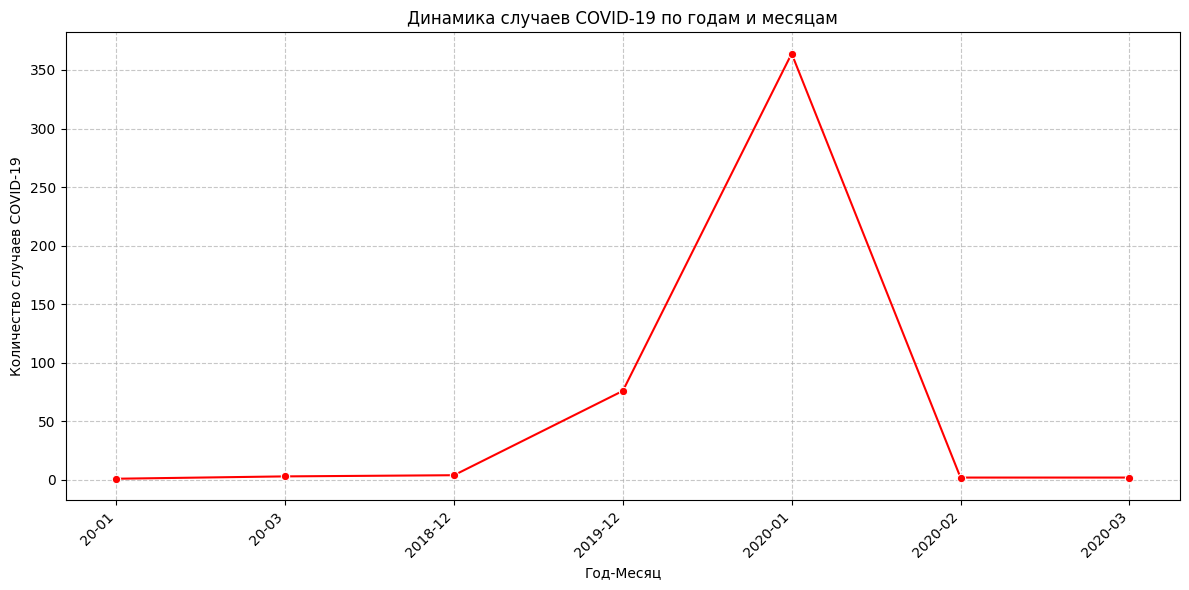


Визуализация 4: ТОП-5 локаций по количеству случаев COVID-19


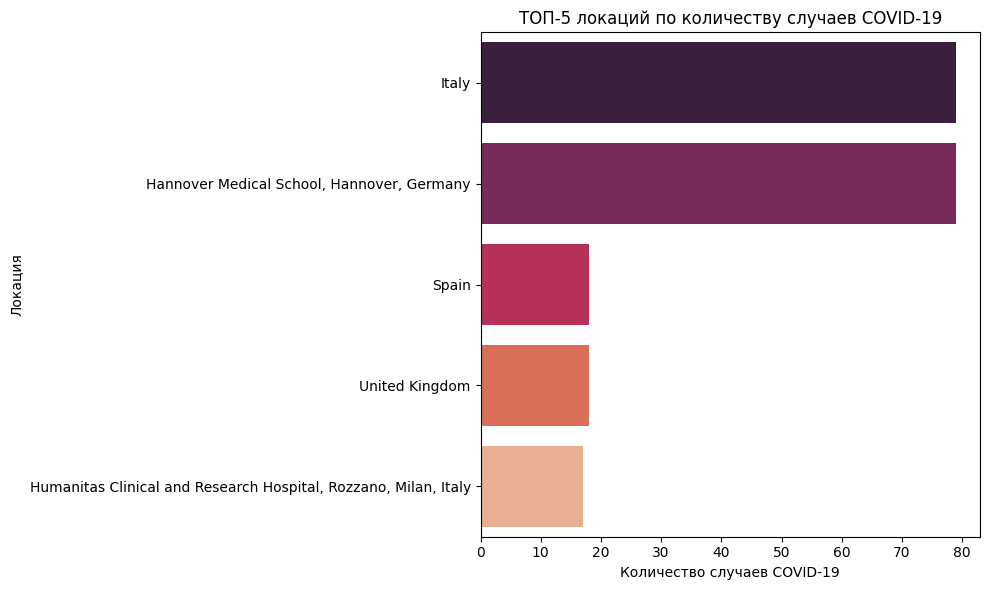

SparkSession остановлена. Визуализация завершена.


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, round
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Инициализация SparkSession 
spark = SparkSession.builder \
    .appName("COVID19_Data_Visualization") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.sql.parquet.datetimeRebaseModeInWrite", "LEGACY") \
    .getOrCreate()

optimized_parquet_path = "hdfs:///covid_dataset/metadata_optimized/"

# Загрузка очищенных и оптимизированных данных
df_viz = spark.read.parquet(optimized_parquet_path)

print("Данные для визуализации загружены.")
df_viz.createOrReplaceTempView("covid_metadata_for_viz")


# График 1: распределение диагнозов 
print("График 1: Распределение диагнозов")
finding_counts_pd = spark.sql("""
    SELECT
        finding_unified,
        COUNT(*) AS count
    FROM
        covid_metadata_for_viz
    GROUP BY
        finding_unified
    ORDER BY
        count DESC
""").toPandas() 

plt.figure(figsize=(8, 8))
plt.pie(finding_counts_pd['count'], labels=finding_counts_pd['finding_unified'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title("Распределение диагнозов")
plt.ylabel('')
plt.show()


# График 2: Распределение случаев COVID-19 по полу
print("График 2: Распределение случаев COVID-19 по полу")
covid_sex_dist_pd = spark.sql("""
    SELECT
        sex,
        COUNT(*) AS count
    FROM
        covid_metadata_for_viz
    WHERE
        is_covid = 1 AND sex IS NOT NULL AND TRIM(sex) != '' AND LOWER(sex) != 'unknown'
    GROUP BY
        sex
    ORDER BY
        count DESC
""").toPandas()

plt.figure(figsize=(7, 6))
sns.barplot(x='sex', y='count', data=covid_sex_dist_pd, palette='viridis', hue='sex', legend=False)
plt.title("Распределение случаев COVID-19 по полу")
plt.xlabel("Пол")
plt.ylabel("Количество случаев COVID-19")
plt.show()


# График 3: Динамика случаев COVID-19 по годам и месяцам 
print("\nВизуализация 3: Динамика случаев COVID-19 по годам и месяцам")
# Берем только COVID-случаи
monthly_covid_cases_pd = spark.sql("""
    SELECT
        CAST(year AS INT) AS year,
        CAST(month AS INT) AS month,
        COUNT(*) AS monthly_covid_cases
    FROM
        covid_metadata_for_viz
    WHERE
        is_covid = 1 AND year IS NOT NULL AND month IS NOT NULL
    GROUP BY
        year, month
    ORDER BY
        year, month
""").toPandas()

# Сделаем колонку 'date_label' для оси X
monthly_covid_cases_pd['date_label'] = monthly_covid_cases_pd['year'].astype(str) + '-' + monthly_covid_cases_pd['month'].astype(str).str.zfill(2)

plt.figure(figsize=(12, 6))
sns.lineplot(x='date_label', y='monthly_covid_cases', data=monthly_covid_cases_pd, marker='o', color='red')
plt.title("Динамика случаев COVID-19 по годам и месяцам")
plt.xlabel("Год-Месяц")
plt.ylabel("Количество случаев COVID-19")
plt.xticks(rotation=45, ha='right') # Поворачиваем метки для лучшей читаемости
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# График 4: ТОП-5 локаций по количеству случаев COVID-19 
print("График 4: ТОП-5 локаций по количеству случаев COVID-19")
top_locations_pd = spark.sql("""
    SELECT
        location,
        COUNT(*) AS covid_cases_count
    FROM
        covid_metadata_for_viz
    WHERE
        is_covid = 1 AND location IS NOT NULL AND TRIM(location) != '' AND LOWER(location) != 'null'
    GROUP BY
        location
    ORDER BY
        covid_cases_count DESC
    LIMIT 5
""").toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='covid_cases_count', y='location', data=top_locations_pd, palette='rocket', hue='location', legend=False)
plt.title("ТОП-5 локаций по количеству случаев COVID-19")
plt.xlabel("Количество случаев COVID-19")
plt.ylabel("Локация")
plt.tight_layout()
plt.show()


# Остановка SparkSession
spark.stop()
print("SparkSession остановлена. Визуализация завершена.")